# Optimal Flyer Routing

## Problem Description

Data in hand:
* ~2300 potential locations within ~50 miles of St. Paul.
* Each location node has a **very** rough estimate (based on < 30 collected samples, i.e. basically guessing) of bulletin-board probability [P(bb)]
* geodesic distance from a single origin point to all nodes
* travel distances/durations from each of the visited location to several hundred nearby nodes (sourced from Gmaps API)

Parameters/Constraints:
* No location should be visited more than once
* Soft limit of 5hrs of travel time in a day (ignoring return time for simplicity)
    * Trying to maximize the number of visited locations in the time span, while favoring nodes with high P(bb)
* Traversal takes places over multiple days, repeating from the same start point
    * After each reset, visited nodes are removed, each node's P(bb) is updated, and a new optimal path is calculated

Challenges:
* Each new travel distance calculation requires a call to Gmaps API, which is a paid resource
    * Here API can be used a free(ish) alternative, but the travel estimates are worse
* Based on the limited amount of collected data, distance should be weighted more heavily than P(bb), but exacting a ratio is difficult

### TODOs: 

**Functionality**
* Use OSMNX or some other means of road data to use actual routes instead of creating estimates based on random forest predictions.
* Consider forms of node clustering rather than graph truncation to limit problem dimensionality
    * MIP Solvers cannot handle more than ~60-70 nodes in a fully connected graph in a reasonable amount of time
* Add node indices as node attribute rather than juggling two separate graphs
* Further research the [Adaptive Heuristic](https://arxiv.org/pdf/1906.07754.pdf) to determine if it is worth keeping 

**Presentation**
* Convert collection of orienteering function into a standalone class
* Documentation on all functions
* Markdown cells to explain outputs
* Explain the Orienteering Problem
* Move helper/non-essential functions into python files to reduce notebook clutter
* Remove frozen cells or move to `flyer_mapping.ipynb`


**Project End Goals**

* Create a seamless end-to-end pipeline from data collection to path updates

### Resources

Orienteering Problem:

http://chekuri.cs.illinois.edu/papers/orienteering-journal.pdf

http://chekuri.cs.illinois.edu/papers/orienteering.pdf

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213777

https://github.com/cwbollinger/OP_simulator/blob/master/orienteering_solver.py

https://link.springer.com/article/10.1057/jors.1984.162

https://dl.acm.org/citation.cfm?id=2700604

https://github.com/mirgee/orienteering_problem_heuristics/blob/master/GRASP_AOP/

Constrained Least-cost Tour:

https://arxiv.org/pdf/1906.07754.pdf

https://patrickohara.github.io/CLT-problem/cltproblem.html#

https://github.com/torressa/cspy

Combinatorial Optimization:

https://en.wikipedia.org/wiki/Combinatorial_optimization

https://www.cvxpy.org/install/index.html

Vehicle Routing Problem:

https://en.wikipedia.org/wiki/Vehicle_routing_problem

https://developers.google.com/optimization/routing/cvrp

Traveling Salesman/General Graph Algorithms:

http://web.stanford.edu/~ashishg/msande111/notes/chapter5

https://www.youtube.com/watch?v=sOTUaT0aABc

https://en.wikipedia.org/wiki/Shortest_path_problem#Road_networks

https://en.wikipedia.org/wiki/K_shortest_path_routing

https://en.wikipedia.org/wiki/List_of_algorithms#Graph_algorithms

Uncategorized:

https://github.com/gboeing/urban-data-science/blob/master/15-Spatial-Cluster-Analysis/cluster-analysis.ipynb

https://github.com/coin-or/pulp

http://www.pyomo.org/related-projects

https://wiki.python.org/moin/PythonForOperationsResearch

https://pysal.readthedocs.io/en/latest/api.html

https://github.com/sacridini/Awesome-Geospatial#python

### Setup & Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import json
import time
import inspect
import hashlib
import difflib
import functools
from pathlib import Path
import urllib.parse as uparse
from collections import Counter
import itertools

import requests
import pickle
from pprint import pprint
from fuzzywuzzy import fuzz
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import scipy as sp
import cvxpy as cx

import googlemaps
import geopy
import geopy.distance as geodist
import geopandas as gpd; gpd.options.display_precision = 6
import shapely

import folium
import folium.plugins
from folium.plugins import MarkerCluster,FeatureGroupSubGroup

import plotly
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

from bing_api import Bing
from here_api import Here
from orienteering import Orienteering
from _config import config

#### Convenience Functions

In [3]:
def lcsubstr(keywords):
    """Find the longest common substring between a list of keywords"""
    skws = sorted(keywords,key=lambda x: len(x))
    substrs = []
    for kw in skws[1:]:
        dsm = difflib.SequenceMatcher(None,skws[0],kw,autojunk=False)
        mtc = dsm.find_longest_match(0,len(dsm.a),0,len(dsm.b))
        substrs.append(dsm.b[:mtc.size])
    return min(substrs, key=lambda x: len(x))

In [4]:
def destring_list(liststr,resep=r',\s*'):
    # 6 digits of precision is accurate to ~11cm, anything further is likely noise
    # https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
    if not isinstance(liststr,str):
        return np.round(liststr,6)
    return np.round([*map(np.float,re.split(resep,liststr.strip('[( )]')))],6)

In [5]:
def asstr(latlon):
    return f'{latlon[0]},{latlon[1]}'

def coord_strcomp(x1,x2):
    return f'{x1[0]}{x1[1]}' == f'{x2[0]}{x2[1]}'

In [6]:
def coord_to(coord, to='place_name', df=None, coord2idx=None):
    df=df if df is not None else df_pdfly
    coord2idx = coord2idx if coord2idx is not None else ll_idx
    return df.at[coord2idx[coord],to] if isinstance(coord,tuple) else df.at[int(coord),to]

In [7]:
def partition_groups(iterable, n_groups=None, max_group_size=None):
    assert (n_groups or max_group_size) is not None, 'exactly one of `n_groups` or `max_group_size` must be provided'
    n_groups = n_groups if n_groups is not None else np.ceil(len(iterable)/(max_group_size))
    return np.array_split(iterable, n_groups)

In [8]:
def gpcode(coords):
    """Long runtime when API key is not provided"""
    url_path='https://plus.codes/api?'
    params = {'address':'{},{}'.format(*coords)}
    resp = requests.get(url_path, params)
    return resp.json()

#### Globals

In [9]:
RAD = 42000 # 40000m ≈ 25 miles
METERMILE = 1609.344
SOURCE = config.geo.CENTERW
BUDGET = 5*60*60 # 5 Hours
px.set_mapbox_access_token(config.MAPBOX_TOKEN)

In [10]:
gmaps = googlemaps.Client(key=config.GMAPS_KEY, timeout=10, retry_over_query_limit=False)
here = Here(config.HERE_APPID,config.HERE_APPCODE)

## Data

**High Success**
* Universities (2/2)
* Community/Recreation Centers (3/3)
* Kwik Trip gas stations (4/4)

**Mixed Success**
* Gas stations general (4/11)
* Laundromats (1/4)

**Limited/No Success**
* Speedway gas stations (0/3)* (one location not recorded)

In [10]:
def update_probs(dfvis, dffly, group_on='keyword', ts_ratio=80, nafill_prob=0.1):
    """Updates probabilities in place and returns constructed mappings
    
    Parameters
    ----------
    dfvis : pd.DataFrame 
        source dataframe containing collected flyer information
    dffly : pd.DataFrame 
        dataframe to be updated with the information in `dfvis`
    group_on : str, (default='keword')
        column name in `dfvis` and `dffly` used to aggregate and generalize probability updates
    ts_ratio : integer (0-100), (default=80) 
        token_set_ratio for fuzzy matching place_names to refine probability updates
    nafill_prob : float, (default=0.1)
        probability to populate unvisited locations
        
    Returns
    -------
    tuple(pd.Series, dict) : 
        {term: probability} parings calculated and used to update dataframes  
    """
    # Initial probablity assignment
    dfvis[group_on] = dfvis[group_on].str.lower()
    grpmap = dfvis.groupby(group_on)['n_flyers'].apply(lambda x: (x>0).mean())
    dfvis['prob_bb'] = dfvis[group_on].map(grpmap)
    dffly['prob_bb'] = dffly[group_on].map(grpmap)
    
    # Refined probability assignment
    # find values where text similarity greater that ts_ratio
    smp = np.argwhere(np.stack(dfvis['place_name'].apply(
        lambda x: np.array([fuzz.token_set_ratio(x,y) for y in dfvis['place_name']])).values) > ts_ratio)
    # convert consecutive indices to groups
    smp_grps = np.split(smp[:,1], np.unique(smp[:,0],return_index = True)[1][1:])
    # remove duplicate groups and singlular groups
    ugrps = filter(lambda x: len(x)>1,map(np.array,np.unique([*map(tuple,smp_grps)])))

    pnmap = {} # place_name mapping
    for g in ugrps:
        prob = (dfvis.loc[g,'n_flyers'] > 0).mean()
        dfvis.loc[g,'prob_bb'] = prob
        pnmap[lcsubstr(dfvis.loc[g,'place_name'])] = prob

    for k,v in pnmap.items(): # fuzzy update with place_name mapping
        dffly.loc[(dffly['place_name'].apply(fuzz.token_set_ratio, s2=k) >= ts_ratio),'prob_bb'] = v
    
    dffly['prob_bb'].fillna(nafill_prob,inplace=True) # set default prob for unvisited locations
    
    return grpmap,pnmap

In [11]:
df_pdfly = pd.read_pickle('data/pdflyers_df.pkl')
df_oppos = pd.read_pickle('data/open_pos_df.pkl')
df_visit = pd.read_pickle('data/visited_details_all_df.pkl')

In [12]:
# Some locations have multiple place_ids, but identical physical location, so we'll drop those for our purposes
# As well as having a unique index for cross ref with df_fdist
df_pdfly = df_pdfly.drop_duplicates('global_code').reset_index(drop=True)
# add consistent geodesic distance to CENTERW column
df_pdfly = df_pdfly.assign(distCW=df_pdfly.latlong.apply(lambda x: geodist.geodesic(SOURCE,x).meters))
# Update bulletin board probability using visited dataframe
update_probs(df_visit,df_pdfly,group_on='keyword')

(keyword
 college              1.000000
 community center     1.000000
 gas station          0.470588
 laundry              0.250000
 park                 1.000000
 recreation center    1.000000
 Name: n_flyers, dtype: float64,
 {'Kwik Trip': 1.0, 'Speedway': 0.0, 'Holiday Stationstores': 0.25})

In [13]:
df_pdfly = pd.concat([pd.Series(config.geo.SOURCEDATA).to_frame().T,df_pdfly],sort=False,axis=0).reset_index(drop=True)

In [14]:
ll_idx = {v:k for k,v in df_pdfly['latlong'].apply(tuple).to_dict().items()}
idx_ll = np.array(list(ll_idx.keys()))
idx2prob = df_pdfly['prob_bb'].to_dict()

In [17]:
df_fdist = pd.read_pickle('data/all_dists_df.pkl')#.rename(lambda x: x.split('.')[1 if len(x.split('.')) > 1 else 0],axis=1).iloc[:,2:]
df_fdist_nb = df_fdist[(df_fdist.dest_ll.str[1] < -92.9) & (df_fdist.geodesic_o2d < RAD)]
df_pdflynb = df_fdist_nb.join(df_pdfly,sort=False).reset_index(drop=True)

In [172]:
df_pdflynb.to_pickle('data/pdflynb_df.pkl')

In [15]:
keep_col = ['place_name', 'prob_bb', 'latlong','distCW','travel_m','travel_secs','place_group','keyword','origin']
df_pdflynb = pd.read_pickle('data/pdflynb_df.pkl')

In [240]:
gdf_fly = gpd.GeoDataFrame(df_pdflynb[keep_col].sample(500))
gdf_fly['geometry']=gdf_fly.apply(lambda x: shapely.geometry.Point(x.latlong) ,axis=1) #shapely.geometry.LineString([config.geo.CENTERW,x.latlong])
gdf_fly.drop(['origin','latlong'],1).to_file('data/geospatial/sampnb_pdfly.shp')
G = nx.read_shp('data/geospatial/sampnb_pdfly.shp')
gpd.read_file('data/geospatial/sampnb_pdfly.shp').head()

## Network Pathing

In [72]:
fdists = [here.distance(config.geo.CENTERW, g)['response']['matrixEntry'] for g in partition_groups(df_pdfly.latlong.values, max_group_size=100)]
df_fdist = json_normalize([y for x in fdists for y in x])
df_fdist['dest_ll'] = [y for x in [
    g[i] for g,i in zip(partition_groups(df_pdfly.latlong.values, max_group_size=100), 
                        partition_groups(df_fdist.destinationIndex, max_group_size=100))] for y in x]
df_fdist['origin_ll'] = str(config.geo.CENTERW)
df_fdist['origin_ll'] = df_fdist.origin_ll.apply(destring_list)
df_fdist['geodesic_o2d'] = df_fdist.apply(lambda x: geodist.geodesic(x.origin_ll,x.dest_ll),axis=1)
df_fdist.to_pickle('data/all_dists_df.pkl')

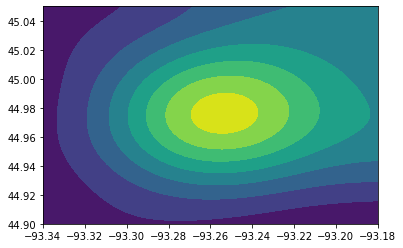

In [24]:
bounds_lat,bounds_lng = (44.9,45.05),(-93.34,-93.18)
hdx,hdy = [*zip(*df_pdfly.latlong)][::-1]
hdx,hdy = np.array(hdx),np.array(hdy)
sns.kdeplot(hdx,hdy,clip=(bounds_lng,bounds_lat),shade=True,cmap='viridis')
high_dens = df_pdfly.latlong[df_pdfly.latlong.str[0].round(2).between(*bounds_lat) & df_pdfly.latlong.str[1].round(2).between(*bounds_lng)]

In [229]:
here=Here(config.HERE_APPID, config.HERE_APPCODE)
high_dens_dists = []
partgrps = partition_groups(high_dens, max_group_size=100)
for o in high_dens.values:
    for grp in partgrps:
        fgrp = grp[~grp.apply(coord_strcomp,x2=o)].values
        high_dens_dists.append((o,fgrp,here.distance(o, fgrp)['response']['matrixEntry']))
pickle.dump(high_dens_dists, open('data/unused_interim/high_density_heredist.pkl','wb'))
hdens_dicts = [{'orig':o, 'dest':dests[d['destinationIndex']], **d['summary']
 } for o, dests, dat in high_dens_dists for d in dat]

In [259]:
df_hddist = pd.DataFrame(hdens_dicts)
hd_o2d = [geodist.geodesic(o,d) for o,d in tqdm(df_hddist[['orig','dest']].values)]
df_hddist['geodesic_o2d'] = hd_o2d
df_hddist.to_pickle('data/hddist_df.pkl')

### Regression Models

In [23]:
df_hddist=pd.read_pickle('data/hddist_df.pkl')

In [24]:
df_data = pd.concat([df_hddist,df_fdist_nb],sort=False).reset_index(drop=True)
df_data['olat'] = df_data.origin_ll.str[0]
df_data['olng'] = df_data.origin_ll.str[1]
df_data['dlat'] = df_data.dest_ll.str[0]
df_data['dlng'] = df_data.dest_ll.str[1]

In [25]:
dfd = df_data.drop(columns=['origin_ll','dest_ll','distance','costFactor'])
dfd = dfd.join(dfd.pop('geodesic_o2d'))
X,y = dfd.iloc[:, 1:], dfd.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [26]:
rfr = RandomForestRegressor(100,n_jobs=-1).fit(X_train,y_train)
ypreds = rfr.predict(X_test)
pickle.dump(rfr,open('models/rf_regr.model','wb'))
r2_score(y_test,ypreds)

0.9807230137467671

In [27]:
data_xy = df_data[['geodesic_o2d','travelTime']].sort_values('geodesic_o2d')
data_xy = data_xy[data_xy['travelTime'] > 50]
#data_xy = data_xy[data_xy.geodesic_o2d < 22000]

X,y = data_xy.iloc[:,0].values.reshape(-1,1),data_xy.iloc[:,1]
Xsq,ysq = np.sqrt(data_xy.iloc[:,0]).values.reshape(-1,1), np.sqrt(data_xy.iloc[:,1])
Xl,yl = np.log(data_xy.iloc[:,0]).values.reshape(-1,1), np.log(data_xy.iloc[:,1])

X1sq = np.hstack([Xsq, np.ones_like(Xsq)])
X1l = np.hstack([Xl, np.ones_like(Xl)])

lrsq = LinearRegression(fit_intercept=False).fit(X1sq,ysq)
lrl = LinearRegression(fit_intercept=False).fit(X1l,yl)

lrsq.score(X1sq,ysq), lrl.score(X1l,yl) # (0.9526346195819283, 0.9474578241037097)

(0.810954547800737, 0.8303248721223381)

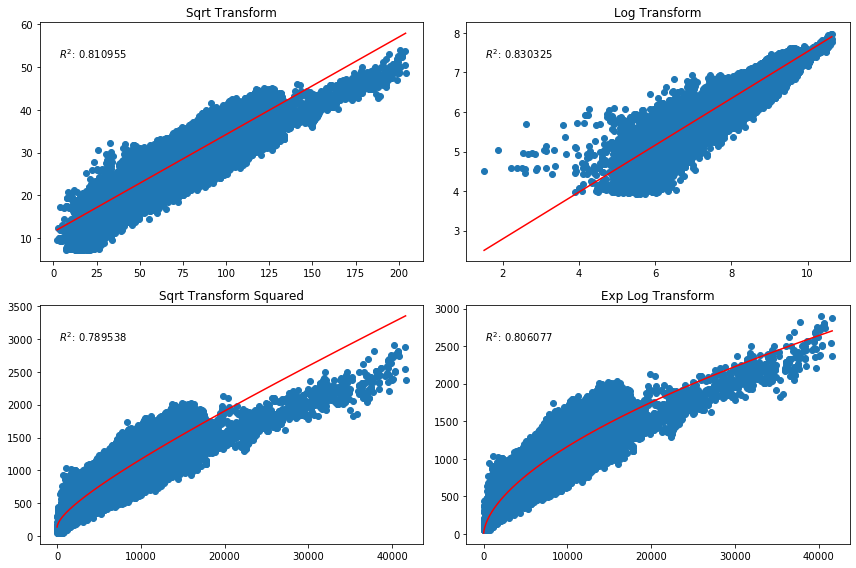

In [31]:
def plot_lr_tsfms(txtpos=(.05,.85)):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes[0,0].scatter(Xsq, ysq)
    axes[0,0].plot(Xsq, X1sq@lrsq.coef_, 'r')
    axes[0,0].annotate(f'$R^2$: {lrsq.score(X1sq,ysq):.6f}',txtpos,xycoords='axes fraction')
    axes[0,0].set_title('Sqrt Transform')

    axes[0,1].scatter(Xl, yl)
    axes[0,1].plot(Xl, X1l@lrl.coef_, 'r')
    axes[0,1].annotate(f'$R^2$: {lrl.score(X1l,yl):.6f}',txtpos,xycoords='axes fraction')
    axes[0,1].set_title('Log Transform');

    axes[1,0].scatter(np.square(Xsq), np.square(ysq))
    axes[1,0].plot(np.square(Xsq), np.square(X1sq@lrsq.coef_), 'r')
    axes[1,0].annotate(f'$R^2$: {r2_score(np.square(ysq),np.square(X1sq@lrsq.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,0].set_title('Sqrt Transform Squared')

    axes[1,1].scatter(np.exp(Xl), np.exp(yl))
    axes[1,1].plot(np.exp(Xl), np.exp(X1l@lrl.coef_), 'r')
    axes[1,1].annotate(f'$R^2$: {r2_score(np.exp(yl),np.exp(X1l@lrl.coef_)):.6f}',txtpos,xycoords='axes fraction')
    axes[1,1].set_title('Exp Log Transform');
    plt.tight_layout()
plot_lr_tsfms()

In [32]:
'R^2 100 Shortest Dists- Sqrt: {:.6f}, Log: {:.6f}'.format(lrsq.score(X1sq[:100],ysq[:100]),lrl.score(X1l[:100],yl[:100]))

'R^2 100 Shortest Dists- Sqrt: -0.521568, Log: -3.369462'

Although the square root transform leads to an overall better $R^2$, it appears that the log transform better fits smaller distance values. Since we will quite often be calculating within a small radius, we'll move forward with this transform. 

If we wanted to create a better performing model while adding minimal complexity, we could train multiple linear regressors on various segments of the data and use a rule based approach.

### Weighting Functions

In [16]:
def geodesic_weight(origin, dest, params=None):
    return geodist.geodesic(origin,dest).meters

In [23]:
def geod_to_travel(xdist,tsfm='log'):
    if tsfm =='log':
        pred= np.exp(np.array([np.log(xdist),1.0])@lrl.coef_)
    else:
        pred = np.square(np.array([np.square(xdist),1.0])@lrsq.coef_)
    return pred

In [24]:
def gtsec_weight(orig,dest):
    return round(geod_to_travel(geodesic_weight(orig,dest)),4)

In [17]:
rfr = pickle.load(open('models/rf_regr.model','rb'))

In [26]:
def gtsec_weightrf(origin,dest,regr=None):
    regr = rfr if regr is None else regr
    xdat = np.array([*origin, *dest, geodesic_weight(origin,dest)],ndmin=2)
    return regr.predict(xdat)[0]

In [18]:
def form_edges(edges):
    weights = Parallel(n_jobs=-1)(delayed(geodesic_weight)(u,v) for u,v in edges)
    return np.array([[*u,*v,w] for (u,v),w in zip(edges,weights)])

In [19]:
def weight_edges(Gedg,regr=None):
    edges = Gedg.edges if isinstance(Gedg,nx.Graph) else Gedg 
    regr = rfr if regr is None else regr
    return [(u,v,round(w,4)) for (u,v),w in zip(edges,regr.predict(form_edges(edges)))]

### Plotting Functions

In [20]:
# https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
cm_GrYlOrRd = mpl.colors.LinearSegmentedColormap.from_list('GrYlOrRd',np.vstack((plt.cm.YlGn_r(np.linspace(0.,1,128)),plt.cm.YlOrRd(np.linspace(0,1,128)))))
def color_edges(G, weight='weight', thresh=[.25,.50,.75], colors=['green','yellow','orange','red']):
    if isinstance(thresh[0],float):
        thresh = np.quantile([w for _,_,w in G.edges.data(weight)],thresh)
        nx.get_edge_attributes(CG,'weight').values()
    edgecols = [colors[0] if w < thresh[0] else 
                (colors[1] if w < thresh[1] else 
                 (colors[2] if w < thresh[2] else colors[3])) 
                for _,_,w in G.edges.data(weight)]
    return edgecols

In [21]:
def plot_cgraph(G, layout=nx.spring_layout, seed=None, noderelab=None, edgcol_thresh=[.25,.50,.75], edgelist=None, figsize=(8,8)):
    fig,ax = plt.subplots(figsize=figsize)
    pos_sl=layout if isinstance(layout, dict) else layout(G) if seed is None else layout(G,seed=seed)
    
    nodecols = ['green' if u in [0,SOURCE] else 'blue' for u in G.nodes]
    edgecols = color_edges(G, thresh=edgcol_thresh)
    nodelabs = {n:coord_to(n,noderelab) for n in G.nodes} if noderelab is not None else None

    nx.draw_networkx_nodes(G, pos=pos_sl, ax=ax, node_color=nodecols)
    nx.draw_networkx_edges(G, pos=pos_sl, ax=ax, edge_color=edgecols, edgelist=edgelist)
    nx.draw_networkx_labels(G,pos=pos_sl, ax=ax, labels=nodelabs, font_size=10, font_color='k')
    plt.axis('off')
    plt.tight_layout()

In [22]:
def plot_map(G, oppth, chpth=None):
    """Plot possible tour routes and included points
    
    Parameters
    ----------
    G : nx.Graph 
        Complete, untrimmed graph that contains nodes in paths.
    oppth : array-like 
        Nodes in orienteering tour to be plotted.
    chpth : array-like, (default=None)
        Nodes in christofides tour to be plotted. If none, it will be calculated.
        
    Returns
    -------
    plotly.figure object
    """
    if chpth is None:
        ccost,cprofit,chpth = chtpath(G,return_path=True)
    if isinstance(oppth[0],(np.integer,int)):
        oppth = [idx_ll[t] for t in oppth]
    if isinstance(chpth[0],(np.integer,int)):
        chpth = [idx_ll[t] for t in chpth]
    
    oppth = np.array(oppth)
    chpth = np.array(chpth)
    
    pldf = pd.DataFrame(G.nodes,columns=['lat','lon'])
    pldf['latlong'] = [*G.nodes]
    pldf['prob_bb'] = pldf['latlong'].map(ll_idx).map(idx2prob)
    pldf['place_name'] = pldf.latlong.apply(coord_to,to='place_name')

    pldf['tour']=pldf['latlong'].apply(lambda x: 'Both' if x in oppth and x in chpth else ('OP' if x in oppth else ('CH' if x in chpth else 'excluded')))
    # pldf['tour'].value_counts()
    pldf['OPdest'] = pldf.latlong.apply(lambda x: np.argwhere(oppth == x)).apply(lambda x: x[0,0] if x.any() else -1)
    pldf['CHdest'] = pldf.latlong.apply(lambda x: np.argwhere(chpth == x)).apply(lambda x: x[0,0] if x.any() else -1)

    pldf_op=pldf[pldf['OPdest'] >= 0].sort_values('OPdest').append(pldf.iloc[0])
    pldf_ch=pldf[pldf['CHdest'] >= 0].sort_values('CHdest').append(pldf.iloc[0])

    cdm = {k:v for k,v in zip(['OP', 'CH', 'Both', 'excluded'],px.colors.qualitative.D3[:4])}
    pfig = px.scatter_mapbox(pldf,'lat','lon',color='tour', hover_data=['prob_bb','OPdest','CHdest'], 
                             zoom=8, color_discrete_map=cdm)
    
    cdata_op = [*zip(pldf_op['OPdest'], pldf_op['CHdest'], pldf_op['prob_bb'], pldf_op['place_name'])]
    cdata_ch = [*zip(pldf_ch['OPdest'], pldf_ch['CHdest'], pldf_ch['prob_bb'], pldf_ch['place_name'])]
    
    hovtmpl = ("OPDest #: <b>%{customdata[0]}</b><br>" 
               "CHDest #: <b>%{customdata[1]}</b><br>" 
               "P(bb): %{customdata[2]:%.2f}" 
               "<extra>%{customdata[3]}</extra>")

    pfig.add_trace(go.Scattermapbox(
        name='OProute',
        mode = "markers+lines+text",
        line={'color':'#1F77B4'},
        lon = pldf_op.lon,
        lat = pldf_op.lat,
        customdata=cdata_op,
        hovertemplate = hovtmpl,
        opacity= 0.7,
        marker = {'size': 6}))

    pfig.add_trace(go.Scattermapbox(
        name='CHroute',
        line={'color':'#FF7F0E'},
        mode = "markers+lines+text",
        lon = pldf_ch.lon,
        lat = pldf_ch.lat,
        customdata=cdata_ch,
        hovertemplate = hovtmpl,
        opacity= 0.7,
        marker = {'size': 6}))

    pfig.update_layout(margin={'l':0,'t':0,'b':0,'r':0}, mapbox={'style': "basic"})
    return pfig

## Adaptive Heuristic

https://arxiv.org/pdf/1906.07754.pdf

**Algorithm 1:** Adaptive heuristic for the Constrained Least-cost Cycle Problem

Suurballe and Tarjan’s algorithm at most n = |V(G)|

**input:** 
```
An undirected graph G with edge weights w : E(G) → ℕ and edge costs c : E(G) → ℕ;
the origin s* ∈ V(G); 
lower and upper weight thresholds W₁, W₂ ∈ ℕ.
```

1. Construct a directed, asymmetric graph (G') from the undirected graph G.
    * [build_auxiliary_node_connectivity](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity.html?highlight=build%20aux#networkx.algorithms.connectivity.utils.build_auxiliary_node_connectivity)
2. For every pair of vertices u, v ∈ V(G'), compute the least-cost pair of vertex-disjoint paths ∆(u, v) between u and v.
    * [node_disjoint_paths](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.connectivity.disjoint_paths.node_disjoint_paths.html)
3. From ∆(u, v), construct a simple cycle C. If s* ∈ C, then C is a candidate solution.
    * [simple_cycles](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html?highlight=simple%20cycle)

**output:** The least-cost weight-feasible simple cycle C* from all candidate solutions C.


**Components**

Given an input graph $G$, we construct a graph $G'$ 
by splitting each vertex $v$ of $G$ into two vertices $v_1$ and $v_2$ 
joined by an edge ($v_1$, $v_2$) of length zero. An edge ($v$, $w$)
of G becomes an edge ($v_2$, $w_1$) of $G$

----

In the CLT/CLC problem, we are given an undirected graph $G$ with vertices $V(G)$ and edges $E(G)$.
Edges have a weight function $w : E(G) \rightarrow N$ and a cost function $c : E(G) \rightarrow N$. 

However, Suurballe’s algorithm requires a directed input graph that is asymmetric, that is if $(x, y)$ is an arc in
the graph, then $(y, x)$ is not  in the graph.

We construct a directed, asymmetric graph $G'$ from the undirected graph G as follows. 
* For each vertex $v \in V(G)$, split $v$ into two vertices $v_1$ and $v_2$ and add them to $V(G')$. 
* Add a directed split arc from $v_1$ to $v_2$ in $G'$ with zero cost and zero weight. For every undirected edge $e_{u,v}$ adjacent to $v$ in $G$,
* add a directed arc from $v_2$ to $u_1$ in $G'$ with the same weight and cost as $e_{u,v}$ in $G$. 

The construction requires O(m + n) time and space complexity.

In [23]:
def path_cost(G, path, path2edges=False, dwell_time=5*60):
    """Returns: total path cost, original path or edge path"""
    
    edge_path = [(p0,p1,G[p0][p1]['weight']+dwell_time) for p0,p1 in nx.utils.pairwise(path)]
    pweight = sum(p[2] for p in edge_path)
    return pweight, edge_path if path2edges else path

In [24]:
def n_permcomb(n,r=2,comb=True):
    return np.math.factorial(n)/(np.math.factorial(r if comb else 1)*np.math.factorial(n-r))

In [25]:
def pretrim_edges(nodes, source=None, max_weight=25*60):
    combs = itertools.combinations(nodes,2) if source is None else itertools.product([source], nodes)
    return [(u,v,w) for u,v,w in weight_edges([*combs]) if w < max_weight] 

def trim_edges(G, max_weight=25*60, weight='weight', **kwargs):
    G.remove_edges_from([(u,v) for u,v,w in G.edges.data(weight) if w > max_weight])
    return G

def trim_degree(G, min_degree=1, **kwargs):
    rm_nodes = [n for n,deg in G.degree if deg < min_degree]
    G.remove_nodes_from(rm_nodes)
    return G

def trim_graph(CG, source=SOURCE, budget=BUDGET, plot=True, noderelab=None, **kwargs):
    mst_CG = nx.tree.minimum_spanning_tree(CG,algorithm=kwargs.get('algorithm','kruskal'))#prim
    tpaths = [nx.shortest_path(mst_CG,source=source,target=n,weight='weight') for n in mst_CG.nodes if n != source]
    for G in [CG,mst_CG]:
        G.remove_nodes_from([path[-1] for cost,path in [path_cost(mst_CG,p) for p in tpaths] if cost > budget/2])
    if plot:
        plot_cgraph(mst_CG, figsize=(8,8), noderelab=noderelab)
    return CG

def full_trim(G, source=None, budget=BUDGET, verbose=False, **kwargs):
    if verbose: print(nx.info(G))
    G = trim_graph(G,source=source, budget=budget, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_edges(G, **kwargs)
    if verbose: print(nx.info(G))
    G = trim_degree(G,**kwargs)
    if verbose: print(nx.info(G))
    return G

In [26]:
def is_asymmetric(Gedg=None):
    edges = Gedg.edges if isinstance(Gedg,nx.Graph) else Gedg   
    symedges = [((u,v),(v,u)) for u,v in edges if (v,u) in edges]
    return (False,symedges) if any(symedges) else True

In [27]:
def mxln_mncost(cost_paths):
    mxln = max([len(path) for cost,path in cost_paths])
    opth = min(filter(lambda p: len(p[1]) == mxln, cost_paths),key=lambda c: c[0])
    return opth

In [28]:
def adaptive_heuristic(CG, source=None, min_weight=None, max_weight=BUDGET):
    A = nx.connectivity.build_auxiliary_node_connectivity(CG)
    R = nx.flow.build_residual_network(A,'capacity')
    flowfn = nx.flow.shortest_augmenting_path # O(n²m) instead of O(nm²) where ,n=nodes,m=edges
    djpaths = [[*nx.node_disjoint_paths(CG,u,v,flow_func=flowfn, auxiliary=A,residual=R)] for u,v in CG.edges]

    djp_costs = [[path_cost(CG,p, True) for p in d] for d in djpaths]
    mintoplen = [mxln_mncost(djc)[1] for djc in djp_costs]
    
    Gdi = nx.DiGraph()
    Gdi.add_weighted_edges_from([(u,v,w) for wdp in mintoplen for u,v,w in wdp])

    cyc_Gdi = [x for x in tqdm(nx.simple_cycles(Gdi))]
    scyc_Gdi = [c for c in cyc_Gdi if source in c] # only consider paths that include source
    # Filter out paths that exceed budget
    pcos = [cpath for cpath in [path_cost(Gdi,p) for p in scyc_Gdi] if cpath[0] < max_weight]
    # Maximize visited locations
    opt_paths = sorted(pcos, key=lambda p: len(p[1]), reverse=True)
    opath = mxln_mncost(opt_paths)
    
    plot_cgraph(Gdi, nx.shell_layout(Gdi,[Gdi.nodes^opath[1], opath[1]]),noderelab='place_name', edgelist=[*nx.utils.pairwise(opath[1])])
    return Gdi,opt_paths

In [29]:
def G_to(G,to='coord_idx',copy=True):
    return nx.relabel_nodes(G,nx.get_node_attributes(G,to),copy=copy)

In [30]:
dfG = df_pdflynb[keep_col].sample(500,random_state=747).sort_values('distCW')
G = nx.complete_graph(pd.Series([SOURCE],index=[0]).append(dfG.latlong.map(tuple)), nx.Graph)
G.add_weighted_edges_from(weight_edges(G)) # ~34 sec -> 14 sec parallelized
G.add_nodes_from([(n, {'coord_idx':ll_idx[n], 'coord':n, 'prob_bb':coord_to(n,'prob_bb')}) for n in G.nodes])

In [31]:
# TODO: decide if/how subgraphs and node/edge attributes could be used to limit graph copying
print(nx.info(G))
Gt = trim_graph(G.copy(), source=SOURCE, budget=BUDGET, plot=False, algorithm='prim')
Gi = nx.relabel_nodes(G,ll_idx)
Gti = nx.relabel_nodes(Gt,ll_idx); Gti.name = 'complete_graph_index_trimmed'
print(nx.info(Gti))

Name: 
Type: Graph
Number of nodes: 501
Number of edges: 125250
Average degree: 500.0000
Name: complete_graph_index_trimmed
Type: Graph
Number of nodes: 82
Number of edges: 3321
Average degree:  81.0000


In [31]:
CG = nx.complete_graph([SOURCE]+sorted(G.nodes,key=lambda x: G.nodes[x]['distCW']), nx.Graph)
CG.add_weighted_edges_from(weight_edges(CG)) # ~34 sec
CG.add_nodes_from([(n, {'coord_idx':ll_idx[n], 'coord':n}) for n in CG.nodes])
print(nx.info(CG))
CGt = trim_graph(CG.copy(),source=SOURCE, budget=BUDGET, plot=False, algorithm='prim')
CGi = nx.relabel_nodes(CG,ll_idx)
CGit = nx.relabel_nodes(CGt,ll_idx); CGit.name = 'complete_graph_index_trimmed'
print(nx.info(CGit))

Name: 
Type: Graph
Number of nodes: 501
Number of edges: 125250
Average degree: 500.0000
Name: complete_graph_index_trimmed
Type: Graph
Number of nodes: 70
Number of edges: 2415
Average degree:  69.0000


In [1]:
Gdi,opt_paths = adaptive_heuristic(Gti, 0, max_weight=BUDGET)

## Christofides TSP

In [32]:
# Minor adaptation from https://github.com/BraveDistribution/pytsp/blob/master/pytsp/christofides_tsp.py
def christofides(G, starting_node=0):
    """
    Christofides TSP algorithm
    http://www.dtic.mil/dtic/tr/fulltext/u2/a025602.pdf
    Args:
        G: undirected networkX Graph
        starting_node: of the TSP
    Returns:
        indices of tour nodes given by christofies TSP algorithm
    """
    Gmst = nx.minimum_spanning_tree(G,algorithm='prim')
    graph = nx.to_numpy_array(G)
    mst = nx.to_numpy_array(Gmst)

    odd_degree_nodes = np.nonzero(np.array([d for _,d in Gmst.degree]) % 2 !=0)[0]
    odd_degree_nodes_ix = np.ix_(odd_degree_nodes, odd_degree_nodes)
    nx_graph = nx.from_numpy_array(-1 * graph[odd_degree_nodes_ix])
    matching = nx.max_weight_matching(nx_graph, maxcardinality=True)
    euler_multigraph = nx.MultiGraph(mst)
    for u,v in matching:
        euler_multigraph.add_edge(odd_degree_nodes[u], odd_degree_nodes[v],
                                  weight=graph[odd_degree_nodes[u]][odd_degree_nodes[v]])
    euler_tour = list(nx.eulerian_circuit(euler_multigraph, source=starting_node))
    path = list(itertools.chain.from_iterable(euler_tour))
    return list(dict.fromkeys(path).keys())# drop repeated nodes # +[starting_node])[:-1] , append starting node

In [33]:
def chtpath(G, budget=BUDGET, dwell_time=0, return_path=False):
    nodetype=type([*G.nodes][0])
    cht_tour = np.array(G)[christofides(G)]
    cht_cpath = np.array(path_cost(G,map(nodetype,cht_tour),True,dwell_time)[1])
    budg_mask = cht_cpath[:,2].cumsum(axis=0) <= budget
    lt_budget = cht_cpath[budg_mask]
    
    tour_cost = lt_budget[:,2].sum()
    tour_profit = sum(coord_to(v,'prob_bb') for v in lt_budget[:,1])
    return (tour_cost, tour_profit, cht_tour[:budg_mask.sum()+1]) if return_path else (tour_cost, tour_profit)

## Orienteering Problem

If the travel cost allows the selection of half of the customers,
the highest number of non-dominated selections will have to be evaluated by the
algorithm. Moreover, determining the TSP route between the selected customers
becomes more complicated when the number of customers increases. Therefore,
the most difficult OP to solve by any kind of enumeration technique, are those
problems where the selected number of customers is a little more than half the
total number of customers.

In [34]:
ori = Orienteering(Gti, n=64, score_mult=1e4, nodeval='prob_bb')

In [35]:
ori.solve(BUDGET)

Using license file C:\Users\Rygu\gurobi.lic
Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Maximum Profit Tour:
0 -> 67 -> 1036 -> 162 -> 859 -> 131 -> 1965 -> 1002 -> 1038 -> 597 -> 148 -> 74 -> 969 -> 438 -> 1559 -> 1097 -> 1571 -> 287 -> 1078 -> 1081 -> 1567 -> 734 -> 1027 -> 988 -> 1071 -> 990 -> 999 -> 77 -> 1049 -> 1738 -> 1497 -> 976 -> 411 -> 1083 -> 1005 -> 1666 -> 827 -> 186 -> 599 -> 570 -> 1101 -> 447 -> 195 -> 1964 -> 1673 -> 210 -> 110 -> 1668 -> 1026 -> 1013 -> 1025 -> 205 -> 1087 -> 1116 -> 134 -> 637 -> 278 -> 137 -> 1016 -> 310 -> 1022 -> 1037 -> 192 -> 1041 -> 0
solve_time: 18.6360 s | tourlen: 65 | cost: 17696.89(17696.89) | profit: 11.29

(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ed872f5b48>)

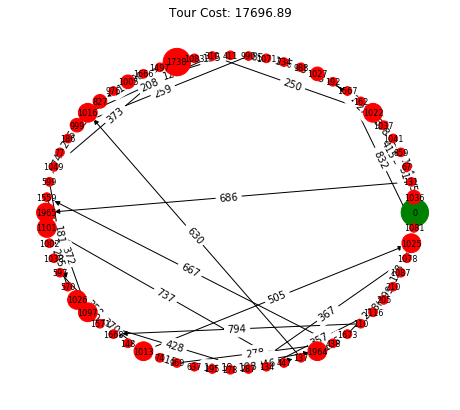

In [49]:
ori.plot_tour()

In [51]:
ori.tour_

array([   0,   67, 1036,  162,  859,  131, 1965, 1002, 1038,  597,  148,
         74,  969,  438, 1559, 1097, 1571,  287, 1078, 1081, 1567,  734,
       1027,  988, 1071,  990,  999,   77, 1049, 1738, 1497,  976,  411,
       1083, 1005, 1666,  827,  186,  599,  570, 1101,  447,  195, 1964,
       1673,  210,  110, 1668, 1026, 1013, 1025,  205, 1087, 1116,  134,
        637,  278,  137, 1016,  310, 1022, 1037,  192, 1041,    0])

In [57]:
ccost,cprofit,cpath = chtpath(Gti,return_path=True)
plot_map(G, ori.tour_, cpath)

In [119]:
def quick_orient(G, n=None, timeout=30, verbose=True):
    cost_matrix,score_vector,nodes = samp_init(G,n=n,score_mult=100) # 33 finished in 26s
    prob, cost = cvx_solve(cost_matrix, score_vector, BUDGET, solver=cx.GUROBI, timeout=timeout, verbose=verbose)
    (x, u), profit = prob.variables(),prob.value
    G,tour,vercost = tour_path(x,cost_matrix,score_vector)
    st = prob.solver_stats.solve_time
    print('solve time: {:0.4f} s | pathlen: {} | cost: {:0.2f}({:0.2f}) | profit: {:0.2f}'.format(st, len(tour), cost.value,vercost, profit))
    print(tour)
    return locals()

## Misc Experiments

In [231]:
CGFt = full_trim(CG.copy(), source=SOURCE, verbose=False, plot=False)

In [47]:
def k_shortest_paths(G, source, target, k, weight='weight'):
    return list(itertools.islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

In [49]:
k_shortest_paths(CGFt, SOURCE, [*CGFt.nodes][3],10)

[[(44.963963, -93.071135), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.951319, -93.090184), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.958415, -93.072514), (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.958415, -93.072514),
  (44.951319, -93.090184),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.943777, -93.096643), (44.951412, -93.086758)],
 [(44.963963, -93.071135), (44.943873, -93.097166), (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.943873, -93.097166),
  (44.943777, -93.096643),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.943777, -93.096643),
  (44.943873, -93.097166),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.943777, -93.096643),
  (44.951412, -93.086758)],
 [(44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.943873, -93.097166),
  (44.951412, -93.086758)]]

In [50]:
[*itertools.islice(nx.find_cliques(CGFt),1)]

[[(45.02648, -93.084699),
  (45.013007, -93.169769),
  (45.050653, -93.0615),
  (45.05799, -93.144726),
  (45.056858, -93.148704),
  (45.012986, -93.169723),
  (45.052676, -93.148451),
  (45.078925, -93.121326),
  (45.035511, -93.18732),
  (45.037597, -93.169993),
  (44.943777, -93.096643),
  (44.991754, -93.24371),
  (44.939446, -93.10898),
  (44.951412, -93.086758),
  (44.958415, -93.072514),
  (44.978835, -93.234137),
  (44.971441, -93.105963),
  (44.987709, -93.229924),
  (44.978061, -93.066208),
  (44.943873, -93.097166),
  (44.963963, -93.071135),
  (44.951319, -93.090184),
  (44.899436, -93.140011)]]

In [51]:
[*nx.centrality.current_flow_closeness_centrality(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 467.83893264228175),
 ((44.958415, -93.072514), 472.54545934424317),
 ((44.978061, -93.066208), 477.3744949683672),
 ((44.951412, -93.086758), 465.17073903639914),
 ((44.951319, -93.090184), 465.70298963740936)]

In [52]:
[*nx.centrality.edge_betweenness_centrality(CGFt,weight='weight').items()][:5]

[(((44.963963, -93.071135), (44.958415, -93.072514)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.978061, -93.066208)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.951412, -93.086758)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.951319, -93.090184)), 0.0033333333333333335),
 (((44.963963, -93.071135), (44.971441, -93.105963)), 0.0033333333333333335)]

In [53]:
nx.average_degree_connectivity(CGFt,weight='weight')

{24: 23.802498819881265, 22: 23.999999999999996, 23: 23.99035521002989}

In [54]:
[*nx.neighbor_degree.average_neighbor_degree(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 23.807009370493496),
 ((44.958415, -93.072514), 23.793651019188392),
 ((44.978061, -93.066208), 23.813808873852313),
 ((44.951412, -93.086758), 23.785268952176942),
 ((44.951319, -93.090184), 23.785817141246472)]

In [55]:
nx.voronoi_cells(CGFt,[SOURCE])

{(44.963963, -93.071135): {(44.899436, -93.140011),
  (44.939446, -93.10898),
  (44.943777, -93.096643),
  (44.943873, -93.097166),
  (44.951319, -93.090184),
  (44.951412, -93.086758),
  (44.958415, -93.072514),
  (44.963963, -93.071135),
  (44.971441, -93.105963),
  (44.978061, -93.066208),
  (44.978835, -93.234137),
  (44.987709, -93.229924),
  (44.991754, -93.24371),
  (45.012986, -93.169723),
  (45.013007, -93.169769),
  (45.02648, -93.084699),
  (45.035511, -93.18732),
  (45.037597, -93.169993),
  (45.050653, -93.0615),
  (45.052676, -93.148451),
  (45.056858, -93.148704),
  (45.05799, -93.144726),
  (45.078925, -93.121326),
  (45.08047, -93.13235),
  (45.08084, -93.145307)}}

In [57]:
[*nx.coloring.greedy_color(CGFt).items()][:5]

[((44.963963, -93.071135), 0),
 ((44.958415, -93.072514), 1),
 ((44.978061, -93.066208), 2),
 ((44.951412, -93.086758), 3),
 ((44.951319, -93.090184), 4)]

In [232]:
nx.barycenter(CGFt,weight='weight')

[(44.948103, -93.093947)]

In [234]:
[*nx.clustering(CGFt,weight='weight').items()][:5]

[((44.963963, -93.071135), 0.4584682740878574),
 ((44.965402, -93.150134), 0.5015542612005199),
 ((44.952654, -93.184722), 0.522408432507696),
 ((44.976282, -93.195165), 0.5576986943476605),
 ((44.964322, -93.198052), 0.5293595436435451)]

## OSMNX

In [18]:
import osmnx as ox

In [132]:
here = Here(config.HERE_APPID, config.HERE_APPCODE)

In [238]:
malformed = df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) < 3]
malformed.head(3)

,place_name,latlong,vicinity,dest_addr,keyword,types,rating,n_ratings,place_id,place_group,geodesic_m,travel_m,travel_secs,origin,global_code,price_level
113,Lake Maria State Park,"[45.315063, -93.951519]","11411 Clementa Ave NW, Monticello","ilver Creek, MN",park,"[campground, tourist_attraction, lodging, park...",4.6,370.0,ChIJVZOc2gWatFIRpusOTu6RuGs,park_camp,1273.033027,80318,3489,"[45.317972, -93.935816]",86Q8828X+29,NaN
2,Otter Lane Book Shop,"[45.197761, -93.388925]","208 E Main St, Anoka","208 E Main St, Anoka",book store,"[book_store, point_of_interest, store, establi...",0.0,0.0,ChIJ76xL-IM_s1IRAg42YKWDUSY,academic,36071.796110,11154,921,"[45.217293, -93.298682]",86Q85JX6+4C,NaN
3,Enchantasys Lingerie & More Intimate Boutique,"[45.219339, -93.423261]","6111 US-10, Ramsey","6111 US-10, Ramsey",book store,"[book_store, electronics_store, home_goods_sto...",4.0,19.0,ChIJzb-DIaU_s1IRv6LSGd3Cfcg,academic,39671.790927,13541,830,"[45.217293, -93.298682]",86Q86H9G+PM,NaN


In [145]:
mal_rgeo = [gmaps.reverse_geocode(x) for x in malformed.latlong]
json.dump(mal_rgeo, open('data/json/rvgeocode_malform_pdfly.json', 'w'))

In [20]:
mal_rgeo = json.load(open('data/json/rvgeocode_malform_pdfly.json', 'r'))
mal_rvgeo_df = pd.concat([json_normalize(x[0]) for x in mal_rgeo], sort=False)

mal_rvgeo_df = mal_rvgeo_df.drop(mal_rvgeo_df.filter(regex='bounds|viewport|compound').columns,1).rename(lambda x: x.split('.')[-1], axis=1)
mal_rvgeo_df['formatted_address'] = mal_rvgeo_df.formatted_address.str.replace(', USA','')

cities = [x for x in map(lambda x: x.group() if x else None, [re.fullmatch(r'([A-Z][a-z]+ ?)+',x) for x in df_pdfly[df_pdfly.dest_addr.str.split(', ').apply(len) > 2].dest_addr.str.split(', ').str[-2].unique()]) if x]
cities.extend(mal_rvgeo_df.formatted_address.str.split(', ').str[-2].unique())
cities = list(set(cities))

In [21]:
gdf_cities = ox.gdf_from_places([f'{city}, MN, USA' for city in cities])
gdf_cities_proj = ox.project_gdf(gdf_cities)
gdf_cproj_poly = gdf_cities_proj[gdf_cities_proj.geom_type != 'LineString']
gdf_cities

In [22]:
lat_min_S, lat_max_N = df_pdfly.latlong.str[0].min(), df_pdfly.latlong.str[0].max()
lng_min_W, lng_max_E = df_pdfly.latlong.str[1].min(), df_pdfly.latlong.str[1].max()

In [23]:
# (South, West, North, East): min_lat, min_lng, max_lat, max_lng
lat_max_N,lat_min_S,lng_max_E,lng_min_W

(45.539975, 44.673566, -92.452544, -94.241201)

In [29]:
%%time
G1 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive_service',simplify=False) #4m
G2 = G1.copy() #30s
ox.save_graphml(G1,filename='street_unsimp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G2 = ox.simplify_graph(G2) # 3m
ox.save_graphml(G2,filename='street_simp_bbox_fly.graphml',folder='data/geospatial') #1m45s
G1 = ox.load_graphml('street_unsimp_bbox_fly.graphml',folder='data/geospatial') #?m
G1_proj = ox.project_graph(G1) #4m25
G1_proj = ox.simplify_graph(G1_proj) #3m
ox.save_graphml(G1_proj,filename='street_simpproj_bbox_fly.graphml',folder='data/geospatial') #1m45s

Wall time: 4min 4s



Note that if you want a projected network, it's usually faster for large cities to 
1. say simplify=False, 
2. then project the graph, 
3. then simplify it. 

Projecting a simplified graph with spatial geometries embedded as edge attributes can take a _long_ time in large networks.

In [33]:
G3 = ox.graph_from_bbox(lat_max,lat_min,lng_max,lng_min, network_type='drive',simplify=False) #3m30s
G3_proj = ox.project_graph(G3) #3m45s
G3_proj = ox.simplify_graph(G3_proj) #?
ox.save_graphml(G3_proj,filename='drive_simpproj_bbox_fly.graphml',folder='data/geospatial') #?

Wall time: 3min 35s


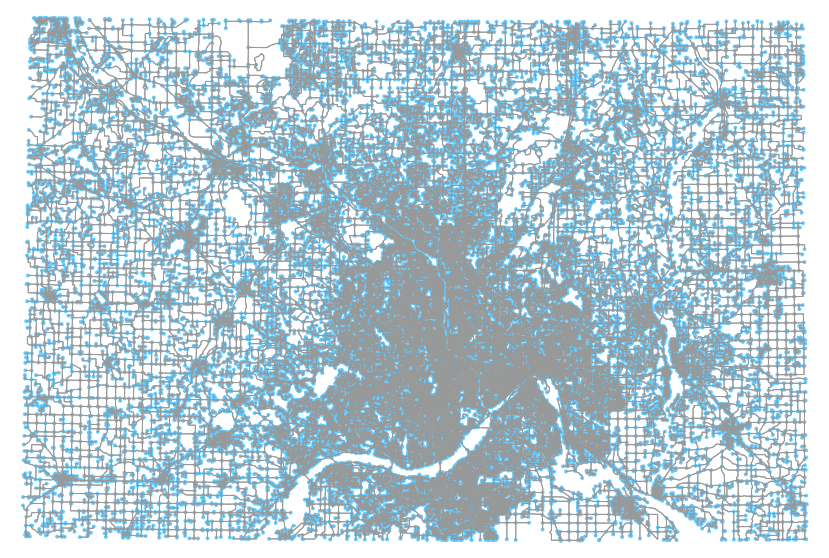

In [37]:
fig, ax = ox.plot_graph(G3_proj,fig_height=10)

In [73]:
%time W10k = ox.graph_from_point(SOURCE,10000,network_type='drive',simplify=False)
#%time W10k = ox.project_graph(W10k)
%time W10k = ox.simplify_graph(W10k)

Wall time: 20.6 s
Wall time: 7.2 s


In [74]:
ox.basic_stats(W10k)

{'n': 15595,
 'm': 42313,
 'k_avg': 5.426482847066367,
 'intersection_count': 13328,
 'streets_per_node_avg': 3.0162231484450146,
 'streets_per_node_counts': {0: 0,
  1: 2267,
  2: 93,
  3: 8456,
  4: 4683,
  5: 91,
  6: 5},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.14536710484129528,
  2: 0.00596344982366143,
  3: 0.5422250721385059,
  4: 0.30028855402372556,
  5: 0.005835203590894517,
  6: 0.0003206155819172812},
 'edge_length_total': 6530951.615000048,
 'edge_length_avg': 154.3485835322489,
 'street_length_total': 3745081.931000025,
 'street_length_avg': 158.70336176794748,
 'street_segments_count': 23598,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.0530701203372628,
 'self_loop_proportion': 0.004230378370713492,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

In [52]:
graph_map = ox.plot_graph_folium(W10k)

In [54]:
graph_map.save('html_out/W10k_osmnx.html')

In [117]:
nbarr = np.array([(d['y'],d['x']) for _,d in sub_W10k.nodes(data=True)])

In [140]:
fig, ax = ox.plot_graph(W10k,fig_height=10, fig_width=10,show=False)
ax.plot(nbarr[:,1],nbarr[:,0],'ro')

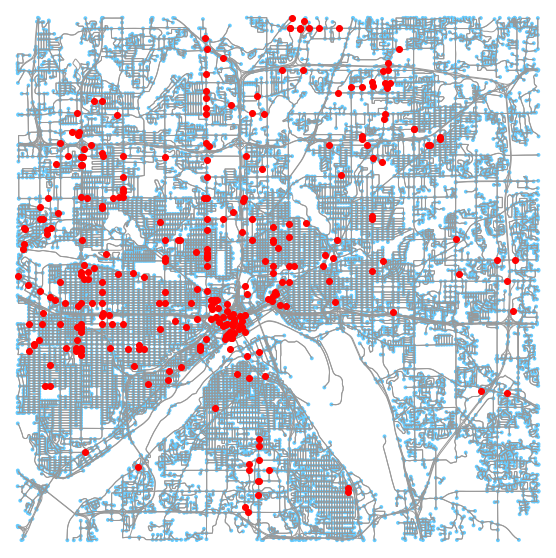

In [141]:
fig

In [129]:
ax.plot(nbarr[:,1],nbarr[:,0],'ro')

In [91]:
locsW10k = df_pdflynb[df_pdflynb.distCW <= 10000]

In [93]:
locsW10k.dest_ll

13      [45.052562, -93.062199]
17      [44.951502, -93.095264]
31      [45.007428, -93.155775]
32      [45.032407, -93.026551]
37      [44.958035, -93.075063]
                 ...           
1692    [44.969713, -93.020687]
1846    [45.046691, -93.106818]
1852    [45.028601, -93.041205]
1853     [44.95913, -93.126742]
1855    [45.001593, -93.077409]
Name: dest_ll, Length: 349, dtype: object

In [96]:
nbnodes = ox.get_nearest_nodes(W10k,locsW10k.dest_ll.str[1],locsW10k.dest_ll.str[0],method='balltree')

In [106]:
sub_W10k = W10k.subgraph(nbnodes).copy()

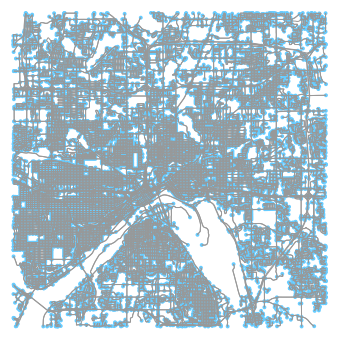

(<Figure size 608.487x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2adf98c6cc0>)

In [108]:
ox.plot_graph(W10k)

In [415]:
nx.draw_networkx_nodes(W10k, nx.layout.planar_layout()

15587

In [68]:
cpoints = np.vstack(df_pdflynb.dest_ll.values)

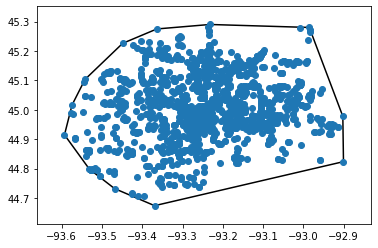

In [69]:
points = cpoints[:,::-1]
hull = sp.spatial.ConvexHull(points)
sp.spatial.convex_hull_plot_2d(hull);

In [70]:
polybb = shapely.geometry.Polygon(points[hull.vertices])

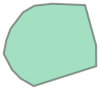

In [404]:
#polybb = ox.round_polygon_coords(polybb,3); polybb

In [72]:
#Gpoly = ox.graph_from_polygon(polybb,'drive',simplify=False,name='metro_points')

In [406]:
Gpoly = ox.project_graph(Gpoly)
Gpoly = ox.simplify_graph(Gpoly)

In [408]:
ox.save_graphml(Gpoly,filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

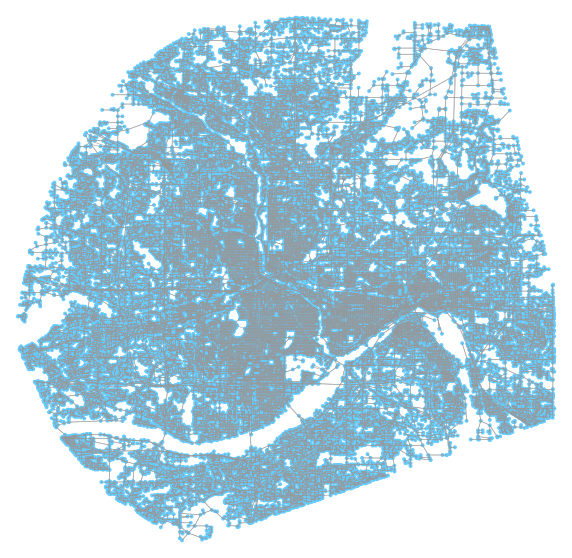

In [413]:
fig,ax = ox.plot_graph(Gpoly,fig_height=10, fig_width=10,edge_linewidth=.6,edge_alpha=.8,use_geom=False)

In [24]:
Gpoly = ox.load_graphml(filename='drive_simpproj_poly_fly.graphml',folder='data/geospatial')

In [318]:
[*itertools.islice(Gpoly.nodes(data=True),1)]

[(2657091855,
  {'y': 4976078.410368689,
   'x': 506367.20645183214,
   'osmid': 2657091855,
   'highway': 'traffic_signals',
   'ref': 'nan',
   'lon': '-92.9193004',
   'lat': '44.93811'})]

In [319]:
np.array(CG.nodes)[0]

array([ 45.152711, -93.16219 ])

In [53]:
coord_to(np.array(CG.nodes)[1],'place_name')

'St. Paul Eastside YMCA'

In [56]:
Gpoly.nodes[ox.get_nearest_node(Gpoly,np.array(CG.nodes)[0])]

{'y': 4992615.313324463,
 'x': 462326.85286295053,
 'osmid': 501191675,
 'highway': 'nan',
 'ref': 'nan',
 'lon': '-93.4787095',
 'lat': '45.0859989'}

In [47]:
Gpoly.nodes(data=True)[ox.get_nearest_node(Gpoly,np.array(CG.nodes)[1])]

{'y': 4992615.313324463,
 'x': 462326.85286295053,
 'osmid': 501191675,
 'highway': 'nan',
 'ref': 'nan',
 'lon': '-93.4787095',
 'lat': '45.0859989'}

In [66]:
nbnodes = ox.get_nearest_nodes(Gpoly,np.array(CG.nodes)[:,0],np.array(CG.nodes)[:,1],method='kdtree')

In [63]:
Gpoly.number_of_nodes()

88589

In [64]:
Gp_sub = Gpoly.subgraph(nbnodes)

In [65]:
Gp_sub.nodes()

NodeView((188063754,))

In [300]:
[*itertools.islice(Gp_sub.nodes(data=True),1)]

[(188565442,
  {'y': 4972946.411169269,
   'x': 505845.41035685764,
   'osmid': 188565442,
   'highway': 'nan',
   'ref': 'nan',
   'lon': '-92.92595',
   'lat': '44.9099201'})]

In [63]:
[Gpoly.nodes(data=True)[n] for n in nnodes]